FileNotFoundError: [Errno 2] No such file or directory: 'image/WBIC/regular&realizable.png'

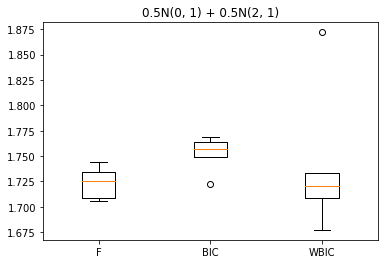

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def p_j(x, y, a, b):
    p0 = (1 - a) * np.exp(-x**2 / 2) / (2 * np.pi)**0.5
    p1 = a * np.exp(-(x - b)**2 / 2) / (2 * np.pi)**0.5
    return (p0**(1 - y)) * (p1**y)


def p(x, a, b):
    return p_j(x, 0, a, b) + p_j(x, 1, a, b)


def prd(x, A, B, K):
    return sum([p(x, A[k], B[k]) for k in range(K)]) / K


def post_sample(X, n, K, burn, beta):
    # 事後分布からのサンプリング
    A, B = [], []
    alpha = (1, 1)
    beta = 1
    gamma = 1
    mu = 0
    for k in range(K):
        a = np.random.beta(alpha[0], alpha[1])
        b = np.random.normal(mu, gamma**(-0.5))
        Y = []
        for i in range(n):
            u = np.random.random()
            x = X[i]
            if u < p_j(x, 0, a, b) / p(x, a, b):
                Y.append(0)
            else:
                Y.append(1)
        sum_Y = sum(Y)
        sum_XY = sum([X[i] * Y[i] for i in range(n)])
        alpha = alpha[0] + beta * sum_Y, alpha[1] + beta * (n - sum_Y)
        mu = (gamma * mu + beta * sum_XY) / (gamma + beta * sum_Y)
        gamma = gamma + beta * sum_Y
        if k >= burn:
            A.append(a)
            B.append(b)
    return A, B


def main(n=100, a=0.5, b=2, s=1, K=1000, burn=200):
    # n:サンプル数, K:MCMCの遷移回数
    # 真の分布: (1-a)N(0,s)+aN(b,s)からサンプリング
    X = []
    for i in range(2 * n):
        u = np.random.random()
        if u < 1 - a:
            x = np.random.normal(0, 1)
        else:
            x = np.random.normal(b, 1)
        X.append(x)
    # 自由エネルギー
    F = 0
    J = 10
    for j in range(J):
        A, B = post_sample(X, n, K, burn, j / J)
        F += -np.log(
            sum([
                np.exp(
                    sum([np.log(p(X[i], A[k], B[k])) for i in range(n)]) / J)
                for k in range(K - burn)
            ]) / (K - burn))
    F = F / n
    # BIC, WBIC
    A, B = post_sample(X, n, K, burn, 1)
    T = sum([-np.log(prd(X[i], A, B, K - burn)) for i in range(n)]) / n
    BIC = T + np.log(n) / n
    A, B = post_sample(X, n, K, burn, 1 / np.log(n))
    WBIC = sum([
        sum([-np.log(p(X[i], A[k], B[k])) for i in range(n)]) / n
        for k in range(K - burn)
    ]) / (K - burn)
    return F, BIC, WBIC


def plot(a=0.5, b=2, s=1, N=100, K=1000, burn=200, ex=5, name='test'):
    F, BIC, WBIC = [], [], []
    for _ in range(ex):
        f, bic, wbic = main(a=a, b=b, s=s, n=N, K=K, burn=burn)
        F.append(f)
        BIC.append(bic)
        WBIC.append(wbic)
    plt.boxplot((F, BIC, WBIC), labels=['F', 'BIC', 'WBIC'])
    if a == 0:
        plt.title('N(0, {})'.format(s))
    else:
        plt.title('{}N(0, {}) + {}N({}, {})'.format(1 - a, s, a, b, s))
    plt.savefig('image/WBIC/{}.png'.format(name))


plot(a=0.5, b=2, s=1, name='regular&realizable')
plot(a=0.5, b=2, s=0.8, name='regular&unrealizable')
plot(a=0, b=0, s=1, name='nonregular&realizable')
plot(a=0, b=0, s=0.8, name='nonregular&unrealizable')
plot(a=0.5, b=0.5, s=0.95, name='delicate')
plot(a=0.01, b=2, s=1, name='unbalanced')